# TinyML Autoencoder for ToyADMOS

Start by getting the data into the notebook. We will focus on the first case of toy car example, and use a subset of that dataset to train an autoencoder.

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import sklearn.metrics

In [2]:
NUMBER_OF_TRAINING_FILES = 100
NUMBER_OF_TEST_FILES = 100

In [3]:
training_path = "/Users/emjn/Documents/DTU/Datasets/ToyConveyor/case1/NormalSound_IND/"
test_path = "/Users/emjn/Documents/DTU/Datasets/ToyConveyor/case1/AnomalousSound_IND/"

# Get the file paths for the sound files in the training and test path
training_files_path = tf.io.gfile.glob(training_path + "*ch1*.wav")
test_files_path = tf.io.gfile.glob(test_path + "*ch1*.wav")

# Let us reduce the amount of training and test samples for the moment
training_files_path = tf.convert_to_tensor(training_files_path[:NUMBER_OF_TRAINING_FILES])
test_files_path = tf.convert_to_tensor(test_files_path[:NUMBER_OF_TEST_FILES])

2022-02-17 15:24:06.313456: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-02-17 15:24:06.313585: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
# Get sample rate
audio_file = training_files_path[0].numpy()
_, sr = librosa.load(audio_file)

In [5]:
def custom_librosa_load(audio_file):
    audio, _ = librosa.load(audio_file.numpy())
    return audio

In [6]:
# This is hopefully faster
training_audio = tf.map_fn(fn=custom_librosa_load, elems=training_files_path, fn_output_signature=tf.float32)
test_audio = tf.map_fn(fn=custom_librosa_load, elems=test_files_path, fn_output_signature=tf.float32)

Now that we have the audio loaded into memory, we create spectrograms based on the audio.

In [7]:
FRAME_SIZE = 2048
HOP_SIZE = 512

In [8]:
def apply_stft(audio_sample):
    mel_spectrogram = librosa.feature.melspectrogram(audio_sample.numpy(), sr=sr, n_fft=2048, hop_length=512, n_mels=256)
    return librosa.power_to_db(mel_spectrogram)

In [9]:
training_magnitudes = tf.map_fn(fn=apply_stft, elems=training_audio)
test_magnitudes = tf.map_fn(fn=apply_stft, elems=test_audio)

Let us visualize a spectrogram of one of the sound files

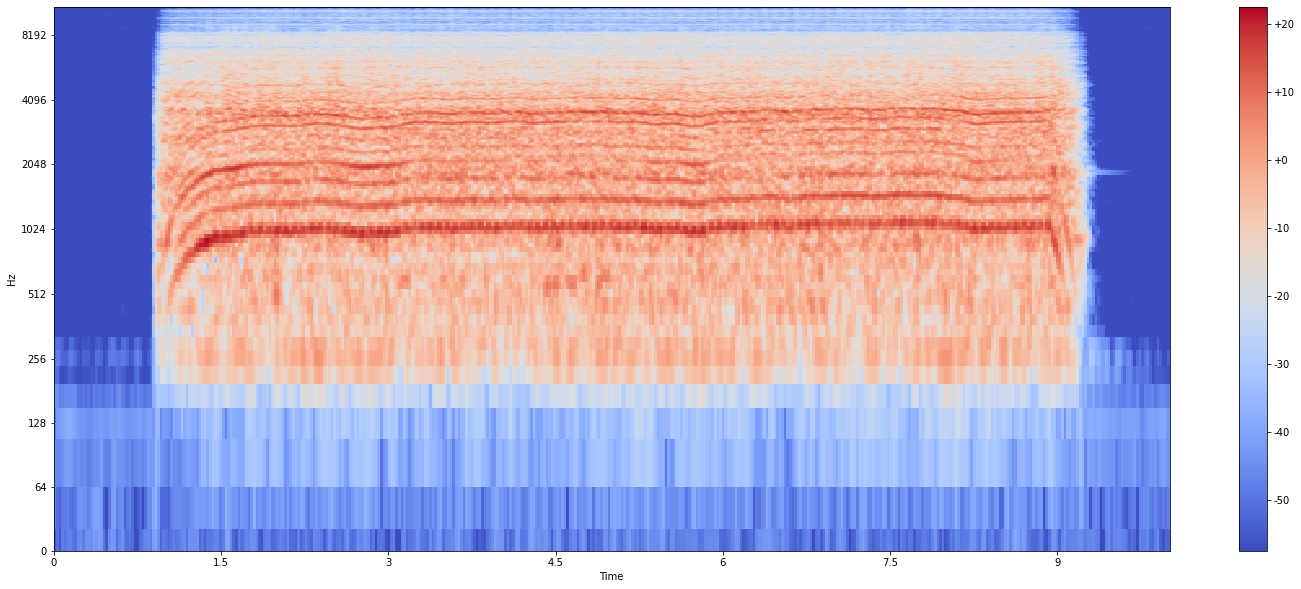

In [10]:
plt.figure(figsize=(25,10))
librosa.display.specshow(training_magnitudes[2].numpy(), sr=sr, hop_length=HOP_SIZE, x_axis="time", y_axis="log")
plt.colorbar(format="%+2.f")

## Defining the model
Having generated the spectrograms we now need to preprocess the them to be suitable for the network. 

In [11]:
training_magnitudes.shape


TensorShape([100, 256, 431])

We need to add a new dimension to the datasets to be able to work with tensorflows convolutions that expect dimensions that would normally be present in an image (dataset_dimension, x, y, channels)

In [12]:
training_magnitudes_4D = training_magnitudes[..., tf.newaxis]
test_magnitudes_4D = test_magnitudes[..., tf.newaxis]

# We pad the spectrograms to multiples of 4 to make max pooling and upsampling result in the same shape
x_train = tf.keras.layers.ZeroPadding2D(padding=((0,0),(1,0)))(training_magnitudes_4D)
x_test = tf.keras.layers.ZeroPadding2D(padding=((0,0),(1,0)))(test_magnitudes_4D)

x_train.shape

TensorShape([100, 256, 432, 1])

As it can be seen on the spectrogram plotted above, the current magnitudes range from about +35 to -45. It is problematic that the values include negative numbers as it will not be possible to reconstruct these using the ReLU activation function. Furthermore neural networks work the best in values ranging from 0-1.

Therefore we apply a shift and a scale to keep the magnitudes of the spectrograms inside this range.

In [13]:
# Getting the min and max value to compute the shift and scale
min_value = tf.reduce_min(x_train)
max_value = tf.reduce_max(x_train)

# Apply shift
x_train = tf.math.subtract(x_train, min_value)
x_test = tf.math.subtract(x_test, min_value)

# Apply scale

x_train = x_train / max_value
x_test = x_test / max_value

## Defining the model
We now define an autoencoder to take the preprocessed spectrograms as input.

In [14]:
encoder = tf.keras.models.Sequential()

encoder.add(tf.keras.layers.Conv2D(32, 3, padding="same",
                                   activation="relu", input_shape=x_train.shape[1:]))
encoder.add(tf.keras.layers.MaxPooling2D())

encoder.add(tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"))
encoder.add(tf.keras.layers.MaxPooling2D())

encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 432, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 216, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 216, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 108, 64)      0         
 2D)                                                             
                                                                 
Total params: 18,816
Trainable params: 18,816
Non-trainable params: 0
_________________________________________________________________


In [15]:
decoder = tf.keras.models.Sequential()

decoder.add(tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu", input_shape=encoder.output.shape[1:]))
decoder.add(tf.keras.layers.UpSampling2D())

decoder.add(tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu", input_shape=encoder.output.shape[1:]))
decoder.add(tf.keras.layers.UpSampling2D())

decoder.add(tf.keras.layers.Conv2D(1, 3, padding="same", activation="relu", input_shape=encoder.output.shape[1:]))

decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 64, 108, 32)       18464     
                                                                 
 up_sampling2d (UpSampling2D  (None, 128, 216, 32)     0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 216, 16)      4624      
                                                                 
 up_sampling2d_1 (UpSampling  (None, 256, 432, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 256, 432, 1)       145       
                                                                 
Total params: 23,233
Trainable params: 23,233
Non-trai

In [16]:
conv_autoencoder = tf.keras.Model(inputs=encoder.input, outputs=decoder(encoder.outputs))

In [17]:
conv_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError())

In [18]:
history = conv_autoencoder.fit(x_train, x_train, epochs=50)

2022-02-17 15:25:37.760831: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-02-17 15:25:37.902511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 1/50
4/4 [==============================] - 2s 287ms/step - loss: 3.5870
Epoch 2/50
4/4 [==============================] - 1s 269ms/step - loss: 0.4492
Epoch 3/50
4/4 [==============================] - 1s 255ms/step - loss: 0.3501
Epoch 4/50
4/4 [==============================] - 1s 251ms/step - loss: 0.2407
Epoch 5/50
4/4 [==============================] - 1s 251ms/step - loss: 0.1611
Epoch 6/50
4/4 [==============================] - 1s 253ms/step - loss: 0.1090
Epoch 7/50
4/4 [==============================] - 1s 255ms/step - loss: 0.0705
Epoch 8/50
4/4 [==============================] - 1s 252ms/step - loss: 0.0700
Epoch 9/50
4/4 [==============================] - 1s 253ms/step - loss: 0.0417
Epoch 10/50
4/4 [==============================] - 1s 268ms/step - loss: 0.0378
Epoch 11/50
4/4 [==============================] - 1s 255ms/step - loss: 0.0347
Epoch 12/50
4/4 [==============================] - 1s 251ms/step - loss: 0.0335
Epoch 13/50
4/4 [==============================] 

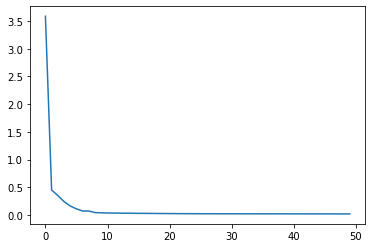

In [19]:
plt.plot(history.history["loss"], label="Training Loss")

## Save the model for another time
Good if training takes a long time

In [29]:
save_path = "./saved_tf_models/"
tf.saved_model.save(conv_autoencoder, save_path)

2022-02-16 14:16:03.896740: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./saved_tf_models/assets


## Take a look at the reconstructions

In [35]:
reconstructions = conv_autoencoder.predict(x_train)

2022-02-17 14:55:27.150978: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [36]:
squeezed_reconstructions = tf.squeeze(reconstructions)

To get back to the original spectrogram scale we shift and scale the reconstructed spectrograms.

In [37]:
scaled_reconstructions = squeezed_reconstructions * max_value

shifted_reconstructions = tf.math.add(scaled_reconstructions, min_value)

### An original spectrogram

In [38]:
# Which spectrogram to visualize
spec_number=8

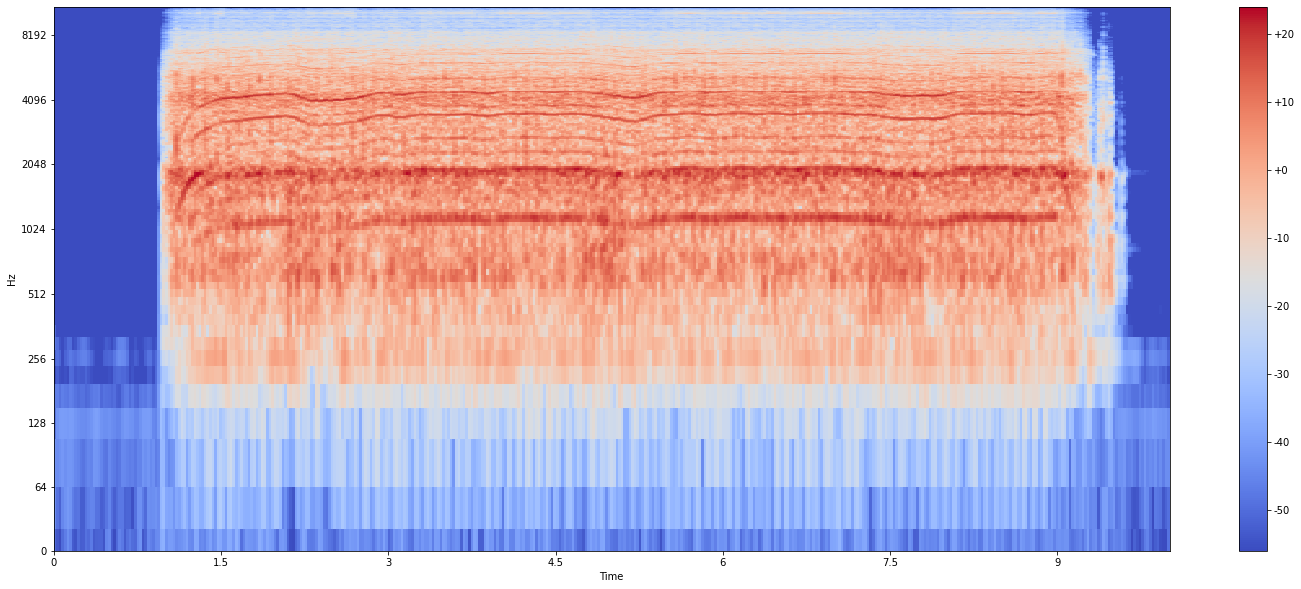

In [40]:
plt.figure(figsize=(25,10))
librosa.display.specshow(test_magnitudes[spec_number].numpy(), sr=sr, hop_length=HOP_SIZE, x_axis="time", y_axis="log")
plt.colorbar(format="%+2.f")

### The reconstructed image
There seems to be an issue with the autoencoder not generating negative numbers!

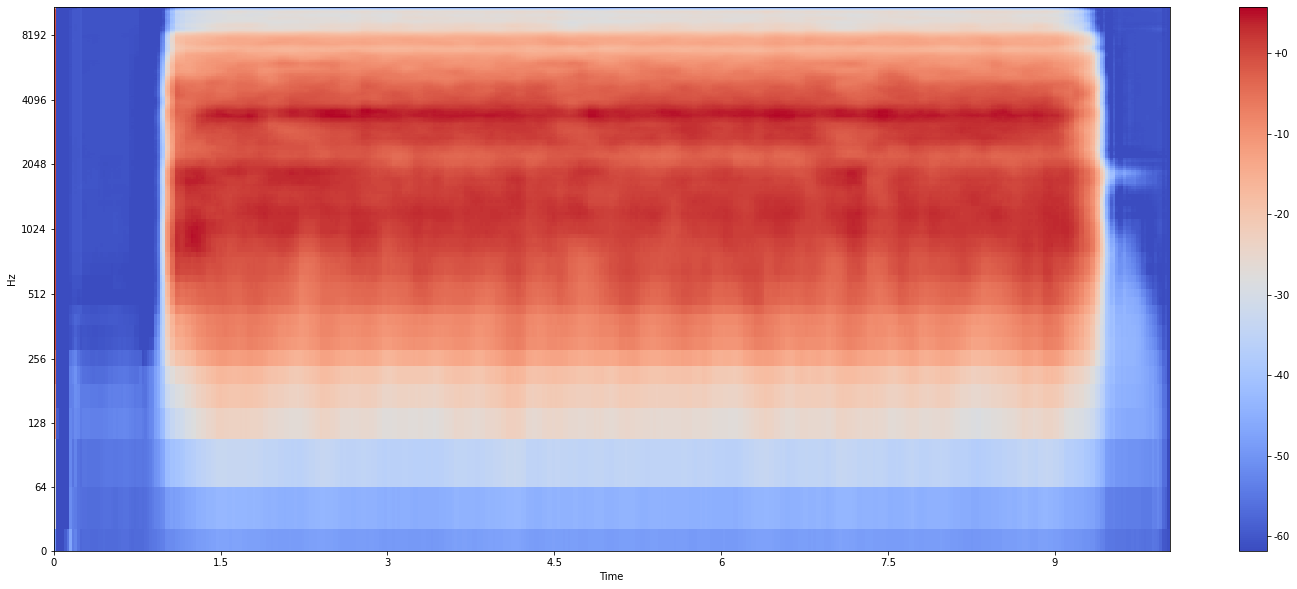

In [41]:
plt.figure(figsize=(25,10))
librosa.display.specshow(shifted_reconstructions[spec_number].numpy(), sr=sr, hop_length=HOP_SIZE, x_axis="time", y_axis="log")
plt.colorbar(format="%+2.f")

## We now have to define a treshold for when to reject a sample as normal

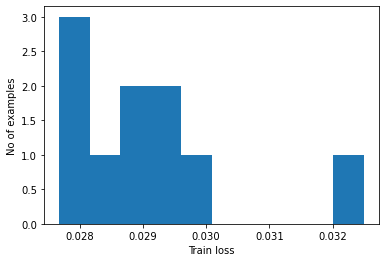

In [42]:
normal_reconstructions = reconstructions

# Reshape the input and reconstructions to work with tensorflow loss functions
reshaped_x_train = tf.reshape(x_train, [x_train.shape[0], tf.math.reduce_prod(x_train.shape[1:])])
reshaped_normal_reconstructions = tf.reshape(normal_reconstructions, [normal_reconstructions.shape[0], tf.math.reduce_prod(normal_reconstructions.shape[1:])])

normal_losses = tf.keras.losses.mse(reshaped_x_train, reshaped_normal_reconstructions)

plt.hist(normal_losses[None,:], bins=10)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

It seems that the loss of normal samples are around 0.028. Lets try to use the test set to see if we see higher reconstruction errors

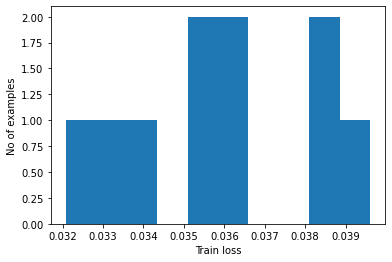

In [43]:
abnormal_reconstructions = conv_autoencoder.predict(x_test)

reshaped_x_test = tf.reshape(x_test, [x_test.shape[0], tf.math.reduce_prod(x_test.shape[1:])])
reshaped_abnormal_reconstructions = tf.reshape(abnormal_reconstructions, [abnormal_reconstructions.shape[0], tf.math.reduce_prod(abnormal_reconstructions.shape[1:])])

abnormal_losses = tf.keras.losses.mse(reshaped_x_test, reshaped_abnormal_reconstructions)

plt.hist(abnormal_losses[None,:], bins=10)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [44]:
np.mean(abnormal_losses)

0.035926927

In [45]:
np.mean(normal_losses)

0.029052347

In [46]:
treshold = np.mean(normal_losses) + np.std(normal_losses)
print("Treshold:", treshold)

Treshold: 0.030354463


In [47]:
def predict(model, data, treshold):
    reconstructions = model(data)
    reshaped_data = tf.reshape(data, [data.shape[0], tf.math.reduce_prod(data.shape[1:])])
    reshaped_reconstructions = tf.reshape(reconstructions, [reconstructions.shape[0], tf.math.reduce_prod(reconstructions.shape[1:])])
    loss = tf.keras.losses.mse(reshaped_data, reshaped_reconstructions)
    return tf.math.less(loss, treshold)

def print_stats(predictions, labels):
    print("Accuracy = {}".format(sklearn.metrics.accuracy_score(labels, predictions)))
    print("Precision = {}".format(sklearn.metrics.precision_score(labels, predictions)))
    print("Recall = {}".format(sklearn.metrics.recall_score(labels, predictions)))

In [48]:
predictions = predict(conv_autoencoder, x_test, treshold)

In [49]:
print_stats(predictions, tf.zeros_like(predictions))

Accuracy = 1.0
Precision = 0.0
Recall = 0.0


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflowM1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflowM1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
